<h1 style="text-align: center;">Predictive Model for Home Prices Notebook</h1>

<p style="text-align: center; font-size: 18px;">By Diego Arévalo, Diego Osborn, Khoi Phan, &amp; Sardor Sobirov</p>

### Libraries

In [1169]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from IPython.display import display
pd.options.display.max_columns = None

### Stat Libraries

In [1170]:
from scipy.spatial import cKDTree
from scipy import stats

### Visualization Libraries

In [1171]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

### ML Libraries

In [1172]:
# ML preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ML metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

## I Dataset

### I.i Identify a dataset

In [1173]:
first_half = pd.read_csv('files/first_half.csv')
second_half = pd.read_csv('files/second_half.csv')
third_half = pd.read_csv('files/third_half.csv')
realtor_data = pd.concat([first_half, second_half, third_half]).reset_index(drop=True).iloc[:, 1:]
realtor_data[realtor_data.select_dtypes(include=['object']).columns] = realtor_data.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
display(realtor_data.head(5))

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,adjuntas,puerto rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,adjuntas,puerto rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,juana diaz,puerto rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,ponce,puerto rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,mayaguez,puerto rico,680.0,NaN,NaN


In [1174]:
display(realtor_data.shape)
display(realtor_data.columns.tolist())
display(realtor_data.dtypes)

(2226382, 12)

['brokered_by',
 'status',
 'price',
 'bed',
 'bath',
 'acre_lot',
 'street',
 'city',
 'state',
 'zip_code',
 'house_size',
 'prev_sold_date']

brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

In [1175]:
zipcode_land = pd.read_csv('files/national-zcta-data.csv', dtype={"GEOID": str})

In [1176]:
display(zipcode_land.shape)
zipcode_land.columns = zipcode_land.columns.str.strip()
zipcode_land = zipcode_land.rename(columns={
    "GEOID": "zip_code",
    "ALAND_SQMI": "land_area",
    "AWATER_SQMI": "water_area",
    "INTPTLAT": "latitude",
    "INTPTLONG": "longitude"})
zipcode_land = zipcode_land.drop(columns=['ALAND', 'AWATER'])
display(zipcode_land.columns.tolist())
display(zipcode_land.dtypes)
display(zipcode_land.head(5))

(33791, 7)

['zip_code', 'land_area', 'water_area', 'latitude', 'longitude']

zip_code       object
land_area     float64
water_area    float64
latitude      float64
longitude     float64
dtype: object

,zip_code,land_area,water_area,latitude,longitude
0,601,64.416,0.308,18.180555,-66.749961
1,602,30.327,1.710,18.361945,-67.175597
2,603,34.356,2.414,18.457399,-67.124867
3,606,44.334,0.005,18.158327,-66.932928
4,610,37.124,1.656,18.295304,-67.125180


In [1177]:
zipcode_pop = pd.read_excel('files/zip_population.xlsx', dtype={"Zip": str})

In [1178]:
display(zipcode_pop.shape)
zipcode_pop.columns = zipcode_pop.columns.str.strip()
zipcode_pop = zipcode_pop.rename(columns={
    "Zip": "zip_code"})
zipcode_pop[zipcode_pop.select_dtypes(include=['object']).columns] = zipcode_pop.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
zipcode_pop = zipcode_pop.drop(columns=['CitySt', 'Coordinates', 'Country', 'State'])
display(zipcode_pop.columns.tolist())
display(zipcode_pop.dtypes)
display(zipcode_pop.head(5))

(40959, 12)

['zip_code', 'population', 'density', 'City', 'St', 'County', 'lat', 'long']

zip_code       object
population      int64
density       float64
City           object
St             object
County         object
lat           float64
long          float64
dtype: object

,zip_code,population,density,City,St,County,lat,long
0,92337,38868,1049.1,fontana,california,san bernardino,34.0498,-117.4706
1,92338,0,0.0,ludlow,california,san bernardino,34.7211,-116.1600
2,92339,1185,32.3,forest falls,california,san bernardino,34.0937,-116.9362
3,92340,1185,32.3,hesperia,california,san bernardino,34.4264,-117.3009
4,92341,203,22.4,green valley lake,california,san bernardino,34.2348,-117.0660


In [1179]:
crime_data = pd.read_csv('files/fbi-crime.csv')
crime_data.columns = [re.sub(r'[^A-Za-z\s]', '', col).strip().replace('\n', '_').replace(' ', '_').lower() for col in crime_data.columns]
object_cols = ['population', 'violent_crime', 'robbery', 'aggravated_assault', 'property_crime', 'burglary', 'larceny_theft', 'motor_vehicle_theft', 'arson']
for i in object_cols:
    crime_data[i] = crime_data[i].str.replace(',', '').astype(float)
crime_data[crime_data.select_dtypes(include=['object']).columns] = crime_data.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
crime_data = crime_data.fillna(0)
crime_data = crime_data.drop(columns=['rape_revised_definition', 'rape_legacy_definition'])
crime_data['state'] = crime_data['state'].str.replace(r'\d', '', regex=True).str.strip()
crime_data = crime_data.drop(columns=['murder_and_nonnegligent_manslaughter', 'robbery', 'aggravated_assault', 'burglary', 'larceny_theft', 'motor_vehicle_theft'])
display(crime_data.columns.tolist())
display(crime_data.dtypes)
display(crime_data.head(5))

['state', 'city', 'population', 'violent_crime', 'property_crime', 'arson']

state              object
city               object
population        float64
violent_crime     float64
property_crime    float64
arson             float64
dtype: object

,state,city,population,violent_crime,property_crime,arson
0,alabama,abbeville,2610.0,9.0,76.0,0.0
1,alabama,adamsville,4414.0,25.0,330.0,0.0
2,alabama,addison,748.0,4.0,28.0,0.0
3,alabama,alabaster,31821.0,132.0,534.0,0.0
4,alabama,albertville,21534.0,30.0,723.0,0.0


In [1180]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
}
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

uni_data = pd.read_csv('files/hd2023.csv', encoding='ISO-8859-1', na_values=['', ' '])
print(uni_data.shape)
uni_data = uni_data[['INSTNM', 'CITY', 'STABBR', 'ZIP', 'OBEREG','COUNTYNM', 'LONGITUD', 'LATITUDE', 'HLOFFER']]
uni_data.columns = [i.lower() for i in uni_data.columns]
uni_data = uni_data[uni_data['stabbr'].isin(us_state_to_abbrev.values())]
uni_data['stabbr'] = uni_data['stabbr'].map(abbrev_to_us_state)
uni_data[uni_data.select_dtypes(include=['object']).columns] = uni_data.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
uni_data['zip'] = uni_data['zip'].apply(lambda x: x[:5])
uni_data['hloffer'] = uni_data['hloffer'].apply(lambda x: -1 if x == 'b' else x).astype(int)
display(uni_data.columns.tolist())
display(uni_data.dtypes)
display(uni_data.head(5))

(6163, 73)


['instnm',
 'city',
 'stabbr',
 'zip',
 'obereg',
 'countynm',
 'longitud',
 'latitude',
 'hloffer']

instnm       object
city         object
stabbr       object
zip          object
obereg        int64
countynm     object
longitud    float64
latitude    float64
hloffer       int64
dtype: object

,instnm,city,stabbr,zip,obereg,countynm,longitud,latitude,hloffer
0,alabama a & m university,normal,alabama,35762,5,madison county,-86.568502,34.783368,9
1,university of alabama at birmingham,birmingham,alabama,35294,5,jefferson county,-86.799345,33.505697,9
2,amridge university,montgomery,alabama,36117,5,montgomery county,-86.174010,32.362609,9
3,university of alabama in huntsville,huntsville,alabama,35899,5,madison county,-86.640449,34.724557,9
4,alabama state university,montgomery,alabama,36104,5,montgomery county,-86.295677,32.364317,9


### I.ii Data cleaning

In [1181]:
display(realtor_data.isnull().sum())

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

In [1182]:
display(zipcode_land.isnull().sum())

zip_code      0
land_area     0
water_area    0
latitude      0
longitude     0
dtype: int64

Dropping rows with missing 'zip_code' since it can't be reliably filled in

In [1183]:
realtor_data = realtor_data.dropna(subset=['zip_code'])

Filling NaN values of `price` steps:

1) Fill in missing prices with median zip code prices

2) Fill in missing prices with median state prices if the zip code group has all missing values

3) Fill in missing prices with global median prices as a final fallback

In [1184]:
# 1)
zip_price = realtor_data.groupby('zip_code')['price'].median()
realtor_data['price'] = realtor_data['price'].fillna(realtor_data['zip_code'].map(zip_price))

# 2)
state_price = realtor_data.groupby('state')['price'].median()
realtor_data['price'] = realtor_data['price'].fillna(realtor_data['state'].map(state_price))

# 3)
global_price_median = realtor_data['price'].median()
realtor_data['price'] = realtor_data['price'].fillna(global_price_median)

Filling NaN values of `bed` and `bath` steps:

1) Fill in missing beds and baths with median zip code beds and baths

2) Fill in missing beds and baths with median state beds and baths if the zip code group has all missing values

3) Fill in missing beds and baths with global median beds and baths as a final fallback

In [1185]:
# 1)
zip_bed = realtor_data.groupby('zip_code')['bed'].median()
zip_bath = realtor_data.groupby('zip_code')['bath'].median()
realtor_data['bed'] = realtor_data['bed'].fillna(realtor_data['zip_code'].map(zip_bed))
realtor_data['bath'] = realtor_data['bath'].fillna(realtor_data['zip_code'].map(zip_bath))

# 2)
state_bed = realtor_data.groupby('state')['bed'].median()
state_bath = realtor_data.groupby('state')['bath'].median()
realtor_data['bed'] = realtor_data['bed'].fillna(realtor_data['state'].map(state_bed))
realtor_data['bath'] = realtor_data['bath'].fillna(realtor_data['state'].map(state_bath))

# 3)
global_bed_median = realtor_data['bed'].median()
global_bath_median = realtor_data['bath'].median()
realtor_data['bed'] = realtor_data['bed'].fillna(global_bed_median)
realtor_data['bath'] = realtor_data['bath'].fillna(global_bath_median)

Filling NaN values of `acre_lot` steps:

1) Fill in missing acreage with median zip code acreage

2) Fill in missing acreage with median state acreage if the zip code group has all missing values

3) Fill in missing acreage with global median acreage as a final fallback

In [1186]:
# 1)
zip_acre = realtor_data.groupby('zip_code')['acre_lot'].median()
realtor_data['acre_lot'] = realtor_data['acre_lot'].fillna(realtor_data['zip_code'].map(zip_acre))

# 2)
state_acre = realtor_data.groupby('state')['acre_lot'].median()
realtor_data['acre_lot'] = realtor_data['acre_lot'].fillna(realtor_data['state'].map(state_acre))

# 3)
global_acre_median = realtor_data['acre_lot'].median()
realtor_data['acre_lot'] = realtor_data['acre_lot'].fillna(global_acre_median)

Filling missing states with `Guam` because the zipcode 96999 is found in Guam1. Filtering `state` to only include US states and Washington DC and remove US territories and else (e.g. New Brunswick is a Canadian province)$^1$

In [1187]:
non_us_states = ['puerto rico', 'virgin islands', 'guam', 'new brunswick']
realtor_data['state'] = realtor_data['state'].fillna('guam')
realtor_data = realtor_data[~realtor_data['state'].isin(non_us_states)].reset_index(drop=True)

Filling NaN values of `city` steps:

1) Fill in missing cities using zip code

2) Fill in missing acreage with state if the zip code group has all missing values

3) Drop rows where city is still missing as a final fallback

In [1188]:
# 1)
zip_to_city = realtor_data.groupby('zip_code')['city'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
realtor_data['city'] = realtor_data['city'].fillna(realtor_data['zip_code'].map(zip_to_city))

# 2)
state_to_city = realtor_data.groupby('state')['city'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
realtor_data['city'] = realtor_data['city'].fillna(realtor_data['state'].map(state_to_city))

# 3)
realtor_data.dropna(subset=['city'], inplace=True)

Filling NaN values of `house_size` steps:

1) Fill in missing house sizes using zip code

2) Fill in missing house sizes with city if the zip code group has all missing values + created temporary `city_state` column to avoid city name ambiguity

3) Fill in missing house sizes with state as a final fallback

In [1189]:
# 1)
zip_size = realtor_data.groupby('zip_code')['house_size'].median()
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['zip_code'].map(zip_size))

# 2)
realtor_data['city_state'] = realtor_data['city'] + ', ' + realtor_data['state']
city_state_size = realtor_data.groupby(['city', 'state'])['house_size'].median()
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['city_state'].map(city_state_size))

# 3)
state_size = realtor_data.groupby('state')['house_size'].median()
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['state'].map(state_size))

Convert `prev_sold_date` to datetime

In [1190]:
realtor_data['prev_sold_date'] = pd.to_datetime(realtor_data['prev_sold_date'], errors='coerce')

Given that there are over 700_000 NaN values of `prev_sold_date`, these null values most likely exist represent that the homes have never been sold before, therefore we will create a binary indicator column `first_sale` where a 1 represents if the home has never been sold before (the NaN values) and 0 if it has (the non-NaN values).

In [1191]:
realtor_data['first_time'] = np.where(realtor_data['prev_sold_date'].isna(), 1, 0)
realtor_data['first_time'] = realtor_data['first_time'].astype('category')

Given that there were `prev_sold_date` dates that happened after the dataset `usa real estate data` was last updated, which was in 2024, I will make those dates NaN

In [1192]:
realtor_data.loc[realtor_data['prev_sold_date'] > '2024-01-01', 'prev_sold_date'] = pd.NaT

Filling NaN values of `prev_sold_date` steps:

1) Fill in missing previous sold dates using zip code

2) Fill in missing previous sold dates with city_state if the zip code group has all missing values

3) Fill in missing previous sold dates with state

4) Fill in missing previous sold dates with global median as a final fallback

drop `city_state` since it was a temporary column and we have cleaned the missing values of all of the features

In [1193]:
# 1)
zip_date = realtor_data.groupby('zip_code')['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(realtor_data['zip_code'].map(zip_date))

# 2)
city_state_date = realtor_data.groupby(['city', 'state'])['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(realtor_data['city_state'].map(city_state_date))

# 3)
state_date = realtor_data.groupby('state')['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(realtor_data['state'].map(state_date))

# 4) 
prev_sold_date_median = realtor_data['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(prev_sold_date_median)

# dropped temp col
realtor_data.drop(columns=['city_state'], inplace=True)

Cleaning up and normalizing the values of the categorical features

In [1194]:
categorical_cols = ['status', 'city', 'state']
realtor_data['status'] = realtor_data['status'].apply(lambda x: x.replace('_', ' '))
realtor_data[categorical_cols] = realtor_data[categorical_cols].apply(lambda x: x.str.strip().str.lower())

Changing types of `zip_code`, `bed`, `bath`, and `house_size` to `int`

In [1195]:
int_cols = ['bed', 'bath', 'house_size']
realtor_data[int_cols] = realtor_data[int_cols].astype(int)

Convert both the categorically encoded features `brokered_by` and `street` to strings and fill the NaN values with 'Not Specified'

In [1196]:
realtor_data['brokered_by'] = realtor_data['brokered_by'].astype(str)
realtor_data['brokered_by'].fillna('Not Specified', inplace=True)

realtor_data['street'] = realtor_data['street'].astype(str)
realtor_data['street'].fillna('Not Specified', inplace=True)

Changing types of the categorically encoded features and `zip_code` to `str`

In [1197]:
id_changer = lambda x: x.split('.')[0]

realtor_data['brokered_by'] = realtor_data['brokered_by'].astype(str).apply(id_changer)
realtor_data['street'] = realtor_data['street'].astype(str).apply(id_changer)
realtor_data['zip_code'] = realtor_data['zip_code'].astype(str).apply(id_changer)

Drop duplicates

In [1198]:
realtor_data = realtor_data.drop_duplicates(keep='first')

Merging the dataframe `zipcode_land` onto `realtor_data` to include `land_area` (in sq. miles), `water_area` (in sq. miles), and latitude & longitude for each `zip_code`.

In [1199]:
realtor_data = realtor_data.merge(zipcode_land, on="zip_code", how="left")

Merging the dataframe `zipcode_pop` onto `realtor_data` to include `population` and	`density` for each `zip_code`.

In [1200]:
realtor_data = realtor_data.merge(zipcode_pop, on='zip_code', how='left')

* Replacing `city` and `state` values with non-missing `City` and `St` values from `zipcode_pop` for cases where `zipcode_land` data was missing. Missing values in `zipcode_land` occured when there was an incorrect zipcode assignment--Kent, Washington, being incorrectly linked to a Los Angeles-area zipcode—-or a zipcode covered a niche area, such as Hat Island in Washington.

* Filling in most of the missing `latitude` and `longitude` values with `lat` and `long` from `zipcode_pop`, as both datasets were merged based on zip code.

* Since I used the `City`, `St`, `lat`, and `long` from `zipcode_pop` to help clean up the dataset more, they are no longer necessary.

In [1201]:
realtor_data.loc[(realtor_data['land_area'].isna()) & (realtor_data['City'].notna()), 'city'] = realtor_data['City']
realtor_data.loc[(realtor_data['land_area'].isna()) & (realtor_data['St'].notna()), 'state'] = realtor_data['St']

realtor_data.loc[realtor_data['latitude'].isna(), 'latitude'] = realtor_data.loc[realtor_data['latitude'].isna(), 'lat']
realtor_data.loc[realtor_data['longitude'].isna(), 'longitude'] = realtor_data.loc[realtor_data['longitude'].isna(), 'long']

realtor_data = realtor_data.drop(columns=['City', 'St', 'lat', 'long'])

Merging the dataframe `crime_data` onto `realtor_data` to include crime statistics for each `city_state` (a combinationation of city and state as a temp identifier).

In [1202]:
realtor_data['city_state'] = realtor_data['city']+', '+realtor_data['state']
crime_data['city_state'] = crime_data['city']+', '+crime_data['state']
realtor_data = realtor_data.merge(crime_data, on='city_state', how='left')

Getting rid of additional columns from the merge that are unnecessary

In [1203]:
realtor_data = realtor_data.drop(columns=['city_state', 'state_y', 'city_y', 'population_y'])
realtor_data = realtor_data.rename(columns={
    "city_x": "city",
    "state_x": "state",
    "population_x": "population"})

Filling some NaN values of `land_area`, `water_area`, `latitude`, and `longitude` with the median for each (`city`, `state`) group

In [1204]:
city_state_medians = realtor_data.groupby(['city', 'state'])[['land_area', 'water_area', 'latitude', 'longitude']].median()
realtor_data = realtor_data.merge(city_state_medians, on=['city', 'state'], suffixes=('', '_median'))
for i in ['land_area', 'water_area', 'latitude', 'longitude']:
    realtor_data[i].fillna(realtor_data[f"{i}_median"], inplace=True)
realtor_data.drop(columns=[f"{i}_median" for i in ['land_area', 'water_area', 'latitude', 'longitude']], inplace=True)

Dropping the remaining rows where `latitude` and `longitude` are missing, as these correspond to non-existent areas, such as out of county, louisiana or out of county, california, or remote locations such as Naukati Bay, Alaska, or Kasaan, Alaska.

In [1205]:
realtor_data = realtor_data.dropna(subset=['latitude', 'longitude'])

Haversine function to calculate the great-circle distance between two coordinates in miles where 3958.8 is the Earth's radius in miles

In [1206]:
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

Merging `uni_data` onto `realtor_data` by grouping by zip code and computing the nearest university once for each unique zip code using the haversine distance formula.

In [1207]:
zip_coords = realtor_data[['zip_code', 'latitude', 'longitude']].dropna().drop_duplicates()

zip_to_uni = {}
for _, zip_row in tqdm(zip_coords.iterrows(), total=len(zip_coords)):
    lat1, lon1 = zip_row['latitude'], zip_row['longitude']
    uni_data['distance'] = haversine(lat1, lon1, uni_data['latitude'], uni_data['longitud'])
    nearest_uni = uni_data.loc[uni_data['distance'].idxmin()]
    zip_to_uni[zip_row['zip_code']] = {
        'closest_uni_name': nearest_uni['instnm'],
        'closest_uni_lat': nearest_uni['latitude'],
        'closest_uni_lon': nearest_uni['longitud'],
        'closest_uni_zip': nearest_uni['zip'],
        'closest_uni_obereg': nearest_uni['obereg'],
        'closest_uni_hloffer': nearest_uni['hloffer'],
        'distance_to_uni': nearest_uni['distance']}

zip_uni_df = pd.DataFrame.from_dict(zip_to_uni, orient='index').reset_index().rename(columns={'index': 'zip_code'})
realtor_data = realtor_data.merge(zip_uni_df, on='zip_code', how='left')
realtor_data['distance_to_uni'] = realtor_data['distance_to_uni'].apply(lambda x: x**2)


100%|██████████| 30173/30173 [00:25<00:00, 1179.32it/s]


Creating a new feature `median_zip_price`, which represents the median price of homes in the zip code (helps compare listing prices to the market norm).

In [1208]:
median_zip_price = realtor_data[realtor_data['status'] == 'for sale'].groupby('zip_code')['price'].median().reset_index(name='median_zip_price')
realtor_data = realtor_data.merge(median_zip_price, on="zip_code", how="left")

Creating a new feature `inventory_count`, which represents the number of homes available for sale (low inventory → higher prices) by zip code.

In [1209]:
inventory_count = realtor_data[realtor_data['status'] == 'for sale'].groupby('zip_code').size().reset_index(name='inventory_count')
realtor_data = realtor_data.merge(inventory_count, on="zip_code", how="left")

Filling in NaN values for the crime statistics using state median crime volumes rather than using the closest zip code where statistics aren't missing. This approach would avoid skewing the data, as it is possible that for rural areas, where data may be missing for entire sectors of zip codes, the closest city where statistics aren't missing could be a large city with high crime volumes, which could distort the crime statistics of those rural areas.

In [1153]:
realtor_data.groupby('state')['violent_crime'].median()

state
alabama                   64.0
alaska                    47.0
arizona                  434.0
arkansas                  72.0
california               343.0
colorado                 137.0
connecticut               32.0
delaware                  57.0
district of columbia    8084.0
florida                  334.0
georgia                   45.0
hawaii                  2437.0
idaho                     97.0
illinois                  50.0
indiana                  112.0
iowa                     108.0
kansas                   128.0
kentucky                  16.0
louisiana                514.0
maine                      6.0
maryland                 240.0
massachusetts             74.0
michigan                  53.0
minnesota                 38.0
mississippi               43.0
missouri                  35.0
montana                   57.0
nebraska                1025.0
nevada                  1419.0
new hampshire             11.0
new jersey                15.0
new mexico               207.0
ne

In [ ]:
crime_stat_cols = ['violent_crime', 'murder_and_nonnegligent_manslaughter', 
                   'robbery', 'aggravated_assault', 'property_crime', 
                   'burglary', 'larceny_theft', 'motor_vehicle_theft', 'arson', 'rape']
for i in crime_stat_cols:
    realtor_data[i] = realtor_data[i].fillna(realtor_data[i].map(realtor_data.groupby('state')[i].median()))

In [1210]:
display(realtor_data.isnull().sum())

brokered_by                 0
status                      0
price                       0
bed                         0
bath                        0
acre_lot                    0
street                      0
city                        0
state                       0
zip_code                    0
house_size                  0
prev_sold_date              0
first_time                  0
land_area                 325
water_area                325
latitude                    0
longitude                   0
population                399
density                   399
County                    399
violent_crime          766097
property_crime         766097
arson                  766097
closest_uni_name            0
closest_uni_lat             0
closest_uni_lon             0
closest_uni_zip             0
closest_uni_obereg          0
closest_uni_hloffer         0
distance_to_uni             0
median_zip_price         1292
inventory_count          1292
dtype: int64

Summary statistics + Outlier Removal

In [1111]:
summary_stats = realtor_data.describe().T
summary_stats['std'] = summary_stats['std'].apply(lambda x: f"{x:.6f}")
summary_stats['max'] = summary_stats['max'].apply(lambda x: f"{x:.1f}")
summary_stats['min'] = summary_stats['min'].apply(lambda x: f"{x:.1f}")
for i in ['25%', '50%', '75%']:
    summary_stats[i] = summary_stats[i].apply(lambda x: f"{x:.3f}")
display(summary_stats)

,count,mean,std,min,25%,50%,75%,max
price,2221453.0,522699.016126,1581125.922484,0.0,165000.000,325000.000,550000.000,1000000000.0
bed,2221453.0,3.230392,1.407114,1.0,3.000,3.000,4.000,473.0
bath,2221453.0,2.434335,1.477538,1.0,2.000,2.000,3.000,830.0
acre_lot,2221453.0,12.977320,699.203387,0.0,0.150,0.250,0.760,100000.0
house_size,2221453.0,4133.703197,1157643.862965,4.0,1387.000,1765.000,2275.000,1040400400.0
land_area,2221128.0,79.257758,168.749236,0.0,10.146,30.988,86.787,13680.1
water_area,2221128.0,2.572972,9.556684,0.0,0.064,0.436,1.872,1426.1
latitude,2221453.0,36.744122,5.537603,19.1,33.010,37.113,40.864,71.3
longitude,2221453.0,-92.258965,15.885806,-164.7,-98.464,-87.605,-80.623,-67.0
population,2221054.0,27453.391733,19302.615714,0.0,12089.000,25048.000,38921.000,122814.0


From the summary statistics we can see that the max `price` is $1\times 10^9$, which is \$1 billion, however this is not realistic because, as of February 2024, the most expensive home in the United States is Gordon Pointe in Naples, Florida, which is listed for \$295 million dollars$^2$. Therefore we can filter `realtor_data` to not include the outliers in `price` that are greater than \$295 million dollars.$^2$

In [235]:
realtor_data = realtor_data[realtor_data['price'] <= 2.95e8]

From the summary statistics we can see that the max `bed` is $473$, however this is not realistic because the Biltmore Estate in Asheville, North Carolina has the most amount of bedrooms in the United States at 35$^3$. Therefore we can filter `realtor_data` to not include the outliers in `bed` that are greater than $35$.$^3$

In [236]:
realtor_data = realtor_data[realtor_data['bed']<=35]

From the summary statistics we can see that the max `bath` is $752$, however this is not realistic because The One in Bel Air, California has the most amount of bathrooms in the United States at 49$^4$. Therefore we can filter `realtor_data` to not include the outliers in `bath` that are greater than $49$.$^4$

In [237]:
realtor_data = realtor_data[realtor_data['bath']<=49]

From the summary statistics we can see that the max `house_size` is $1.0404004\times 10^9$, which is around 1.04 billion, however this is not realistic because the Biltmore Estate in Asheville, North Carolina, the largest home in the United States by square footage, is at 175,000 sq ft$^5$. Therefore we can filter `realtor_data` to not include the outliers in `house_size` that are greater than $175,000$.$^5$

In [238]:
realtor_data = realtor_data[realtor_data['house_size']<=175_000]

Cleaned summary stats

In [239]:
summary_stats = realtor_data.describe().T
summary_stats['std'] = summary_stats['std'].apply(lambda x: f"{x:.6f}")
summary_stats['max'] = summary_stats['max'].apply(lambda x: f"{x:.1f}")
display(summary_stats)

,count,mean,std,min,25%,50%,75%,max
price,2221086.0,520912.160402,1253941.416711,0.000000,165000.000000,325000.000000,550000.000000,295000000.0
bed,2221086.0,3.223506,1.124289,1.000000,3.000000,3.000000,4.000000,35.0
bath,2221086.0,2.429103,1.097568,1.000000,2.000000,2.000000,3.000000,49.0
acre_lot,2221086.0,12.977794,699.260909,0.000000,0.150000,0.250000,0.760000,100000.0
house_size,2221086.0,1986.499887,1238.009620,4.000000,1386.000000,1764.000000,2275.000000,156244.0
land_area,2220250.0,79.247042,168.719857,0.004000,10.146000,30.983000,86.787000,13680.1
water_area,2220250.0,2.572409,9.553223,0.000000,0.064000,0.436000,1.872000,1426.1
latitude,2221086.0,36.744419,5.537264,19.065548,33.009665,37.113416,40.864652,71.3
longitude,2221086.0,-92.256305,15.882723,-164.654295,-98.464401,-87.605318,-80.622302,-67.0
population,2220687.0,27453.019307,19302.330375,0.000000,12089.000000,25048.000000,38921.000000,122814.0


### I.iii Perform an exploratory data analysis

#### Univariate Analysis

Distributions of the numeric features

In [189]:
realtor_data_copy = realtor_data.copy()

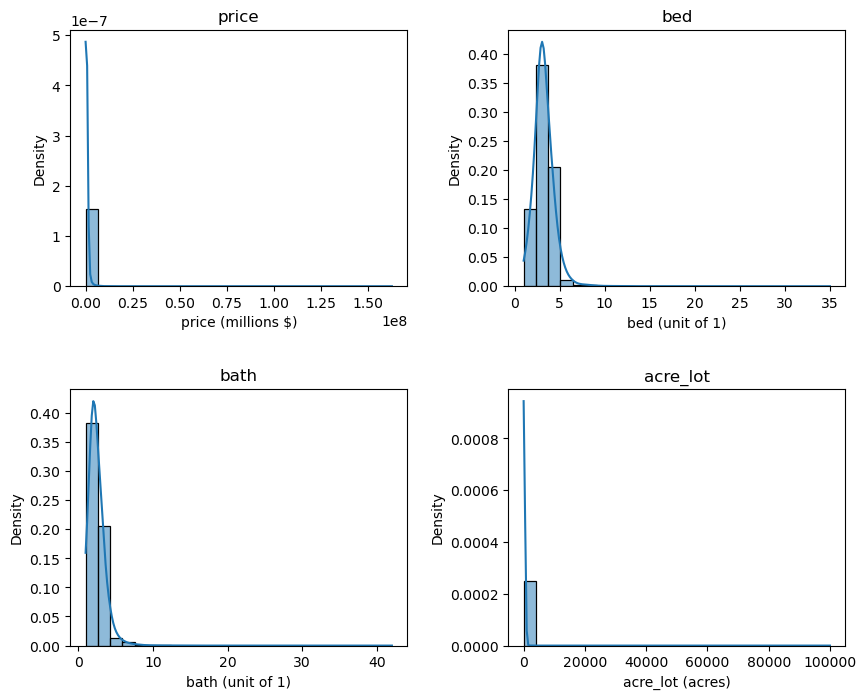

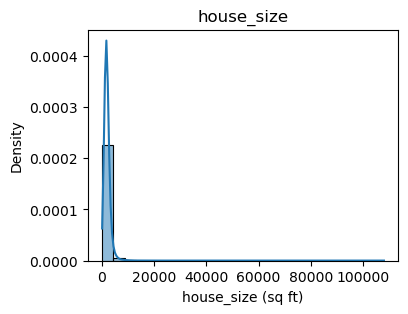

In [190]:
numeric_cols = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
sampled_data = realtor_data.sample(100000, random_state=42)  # Sample 100K rows

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for ax, col in zip(axes.flatten(), numeric_cols[:4]):
    sns.histplot(data=sampled_data, x=col, kde=True, stat="density", kde_kws={"bw_adjust": 5}, bins=25, ax=ax)
    ax.set_title(col)
    if col in ['bed', 'bath']:
        ax.set_xlabel(f'{col} (unit of 1)')
    elif col == 'price':
        ax.set_xlabel(f'{col} (millions $)')
    else:
        ax.set_xlabel(f'{col} (acres)')

plt.figure(figsize=(4, 3))
sns.histplot(data=sampled_data, x=numeric_cols[4], kde=True, stat="density", kde_kws={"bw_adjust": 5}, bins=25)
plt.title(numeric_cols[4])
plt.xlabel(f'{numeric_cols[4]} (sq ft)')
plt.show()

Since the histograms of `price`, `acre_lot`, and `house_size` show extreme right-skewness, we will apply a log transformation to spread out the lower values.

In [191]:
RE_data = realtor_data

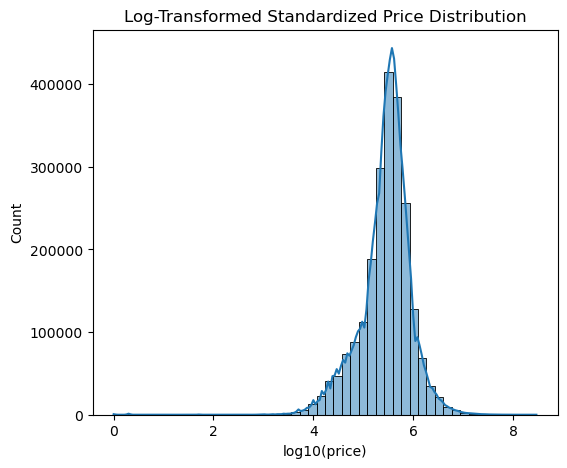

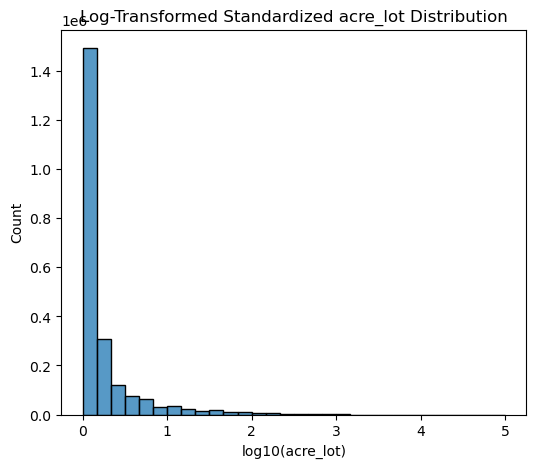

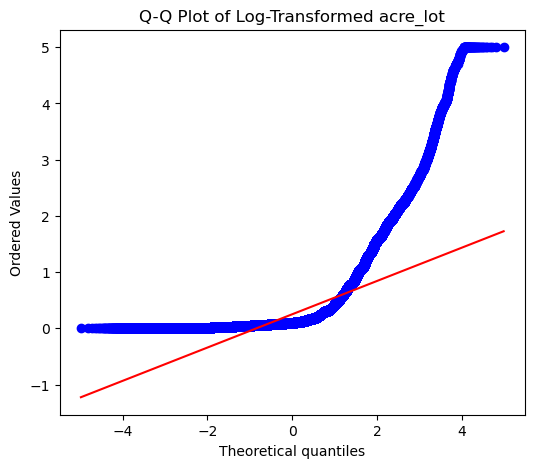

In [192]:
# Price
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=realtor_data, x=np.log10(realtor_data['price'] + 1), kde=True, bins=50, ax=ax)
ax.set_title("Log-Transformed Standardized Price Distribution")
ax.set_xlabel("log10(price)")
plt.show()

# acre_lot
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=realtor_data, x=np.log10(realtor_data['acre_lot'] + 1), kde=False, bins=30, ax=ax)
ax.set_title("Log-Transformed Standardized acre_lot Distribution")
ax.set_xlabel("log10(acre_lot)")
plt.show()

# Q-Q plot
fig, ax = plt.subplots(figsize=(6, 5))
stats.probplot(np.log10(realtor_data['acre_lot'] + 1), dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Log-Transformed acre_lot")
plt.show()

Code below don't work

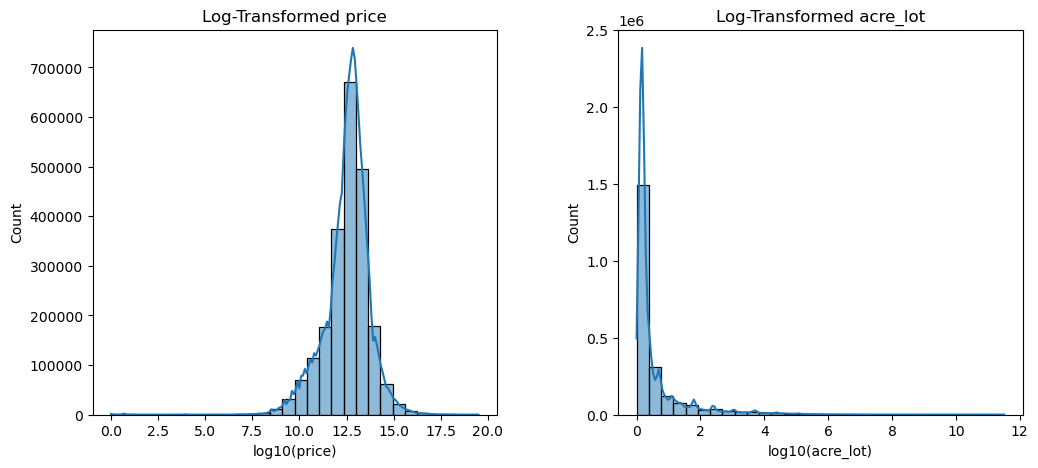

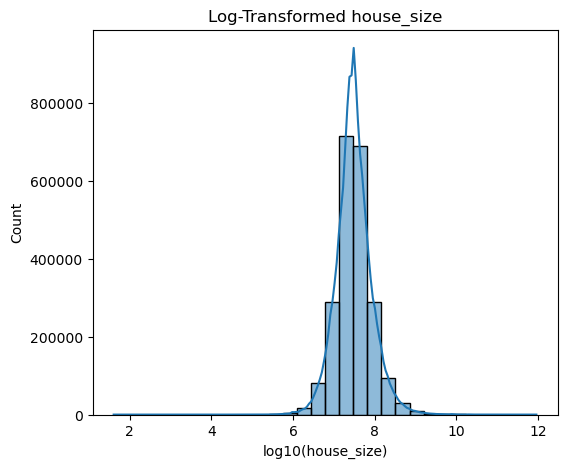

In [193]:
# Plotting log-transformed standardized values for 'price' and 'acre_lot'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for ax, col in zip(axes.flatten(), ['price', 'acre_lot']):
    # Plot log-transformed standardized values
    sns.histplot(data=realtor_data_copy, x=np.log1p(realtor_data_copy[col]), kde=True, bins=30, ax=ax)
    ax.set_title(f"Log-Transformed {col}")
    ax.set_xlabel(f"log10({col})")

plt.show()

# Plotting for 'house_size'
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=realtor_data_copy, x=np.log1p(realtor_data_copy['house_size']), kde=True, bins=30)
ax.set_title("Log-Transformed house_size")
ax.set_xlabel("log10(house_size)")
plt.show()

In [95]:
# Ensure only numeric columns are considered
numeric_cols = realtor_data.select_dtypes(include=['number']).columns

# Compute skewness only for numeric columns
skewed_cols = numeric_cols[realtor_data[numeric_cols].skew() > 2].tolist()

# Apply log transformation for highly skewed columns
realtor_data[skewed_cols] = realtor_data[skewed_cols].apply(lambda x: np.log1p(x))

print(f"Log-transformed columns: {skewed_cols}")

Log-transformed columns: ['price', 'bed', 'bath', 'acre_lot', 'house_size']


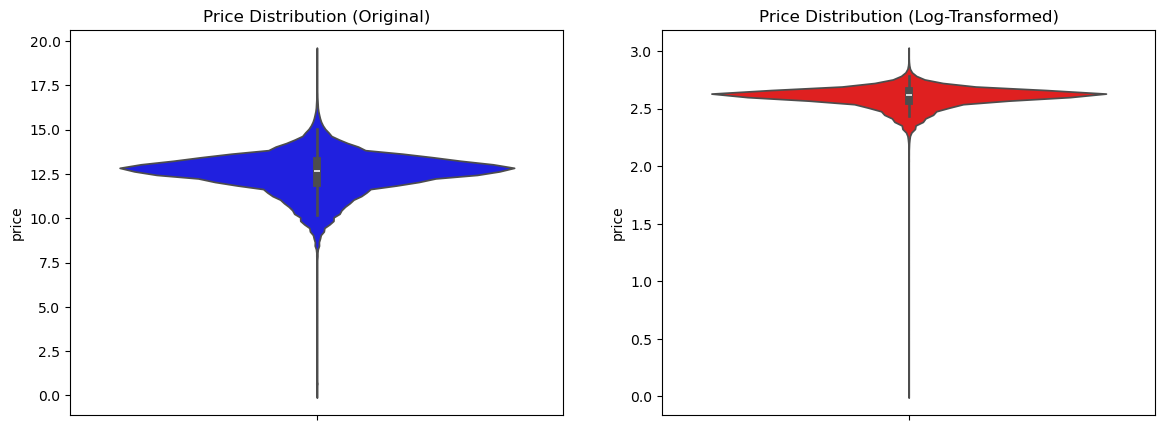

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before log transformation
sns.violinplot(y=realtor_data['price'], ax=axes[0], color='blue')
axes[0].set_title('Price Distribution (Original)')

# After log transformation
sns.violinplot(y=np.log1p(realtor_data['price']), ax=axes[1], color='red')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.show()

## Finding Outliers

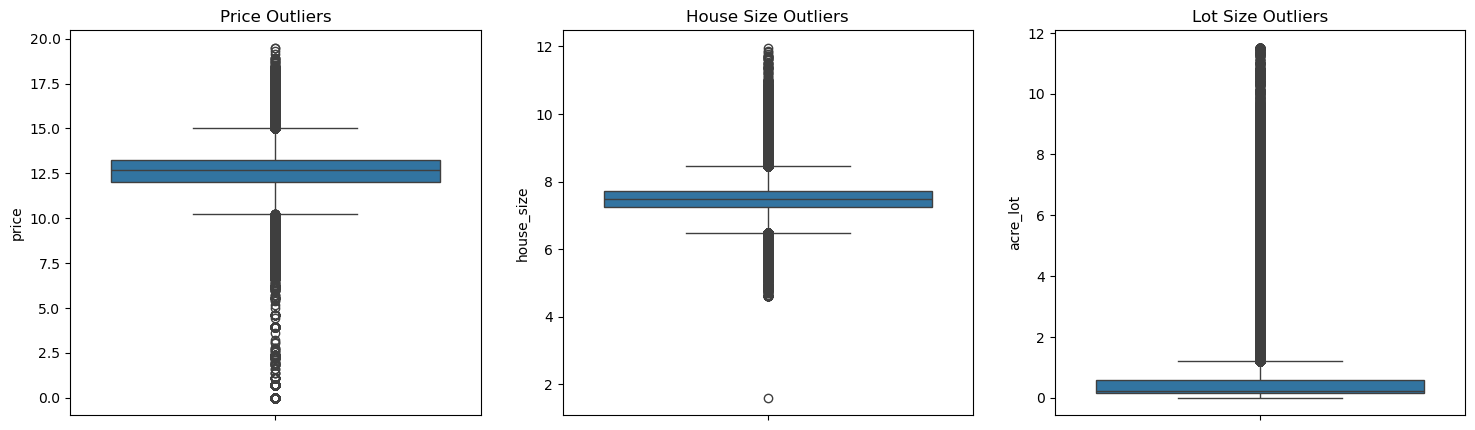

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=realtor_data['price'], ax=axes[0]).set_title('Price Outliers')
sns.boxplot(y=realtor_data['house_size'], ax=axes[1]).set_title('House Size Outliers')
sns.boxplot(y=realtor_data['acre_lot'], ax=axes[2]).set_title('Lot Size Outliers')

plt.show()

## Heatmap

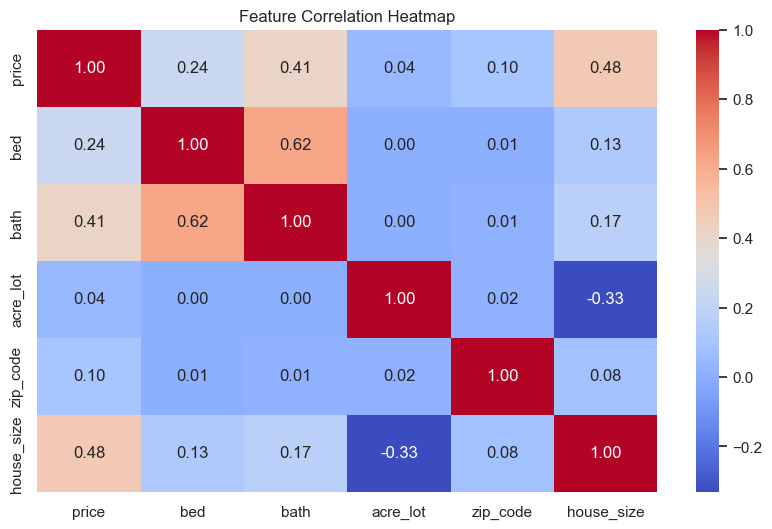

In [237]:
numeric_data = realtor_data.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

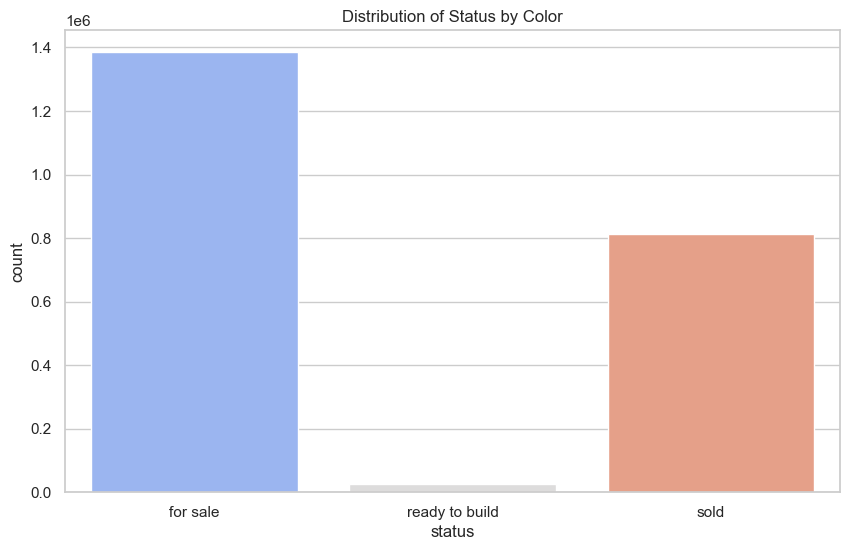

In [217]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='status', data=realtor_data, hue='status', palette='coolwarm')
plt.title("Distribution of Status by Color")
plt.show()


# Non log data vizualization

In [193]:
outlier_list = ['price','bed','house_size']
max = 3
for i in outlier_list:
    z_scores = np.abs((RE_data[i] - RE_data[i].mean()) / RE_data[i].std())
    RE_data = RE_data[z_scores <= max]

## Avg house size by state

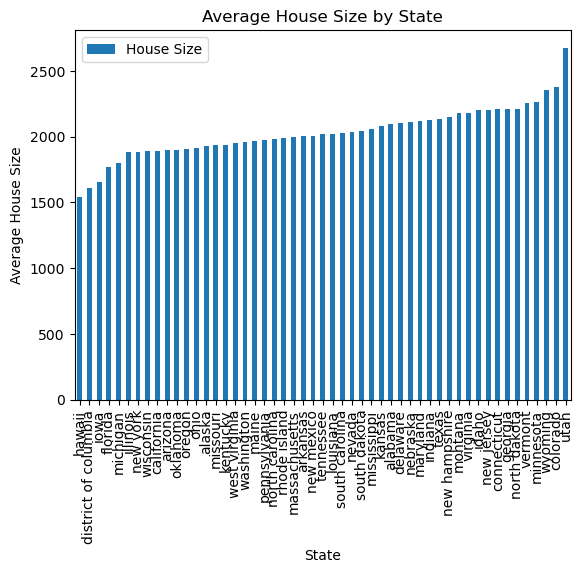

In [189]:
avg_house_size = RE_data[['state','house_size']]\
                .groupby('state')\
                .mean()\
                .sort_values('house_size')\
                .rename(columns={'house_size':'House Size'})
avg_house_size.index.name = 'State'

avg_house_size.plot(kind='bar');
plt.title('Average House Size by State');
plt.ylabel('Average House Size');

## Price range frequency

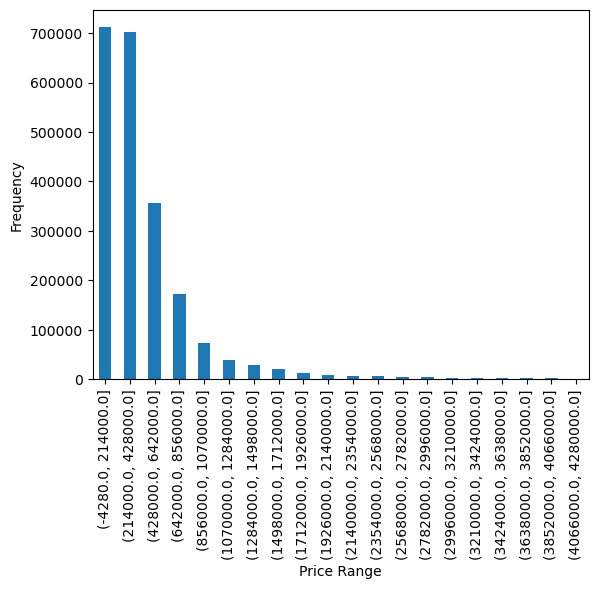

In [195]:
num_bins = 20
price_range = (0,100)

hist_price = pd.cut(RE_data['price'], bins=num_bins)

dist_houseprice = hist_price.value_counts().sort_index().round(2).plot(kind='bar');

plt.xlabel('Price Range')
plt.ylabel('Frequency')

dist_houseprice;

## Price distribution on bedroom

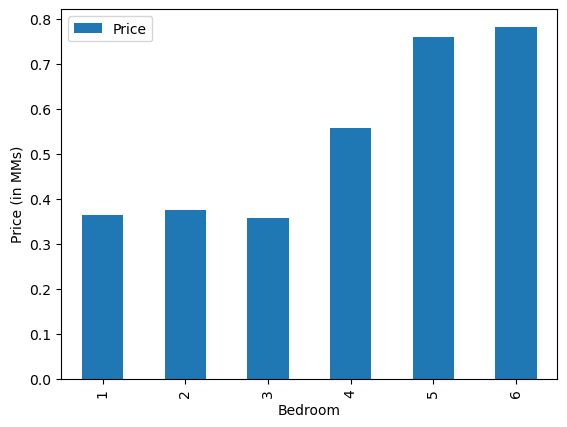

In [197]:
def as_millions(value):
    return value/1_000_000


avg_price_bdr = RE_data[['price','bed']]\
                .groupby('bed')\
                .mean()\
                .rename(columns={'price':'Price'})\
                .apply(as_millions)
    
avg_price_bdr.index.name = "Bedroom"

avg_price_bdr

avg_price_bdr.plot(kind='bar')
plt.ylabel('Price (in MMs)');

## Avg price of State

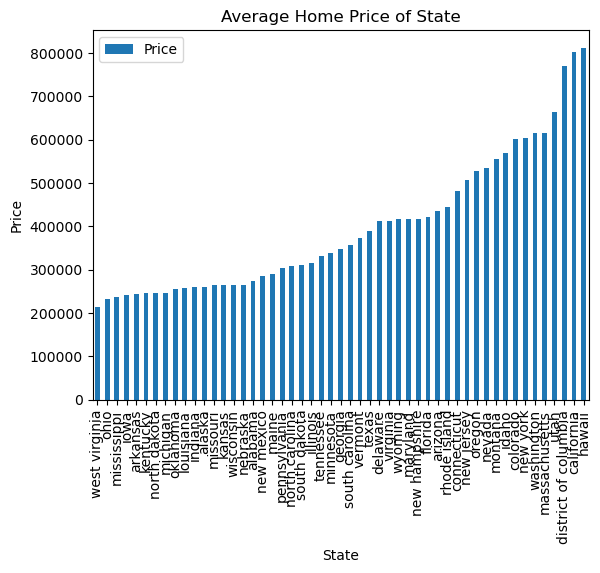

In [204]:
avg_price_state = RE_data[['state','price']]\
                .groupby('state')\
                .mean()\
                .sort_values('price')\
                .rename(columns={'price':'Price'})
avg_price_state.index.name = 'State'

avg_price_state.plot(kind='bar')
plt.ylabel('Price')
plt.title('Average Home Price of State');

In [225]:
## Highest Average Home Price accross citys

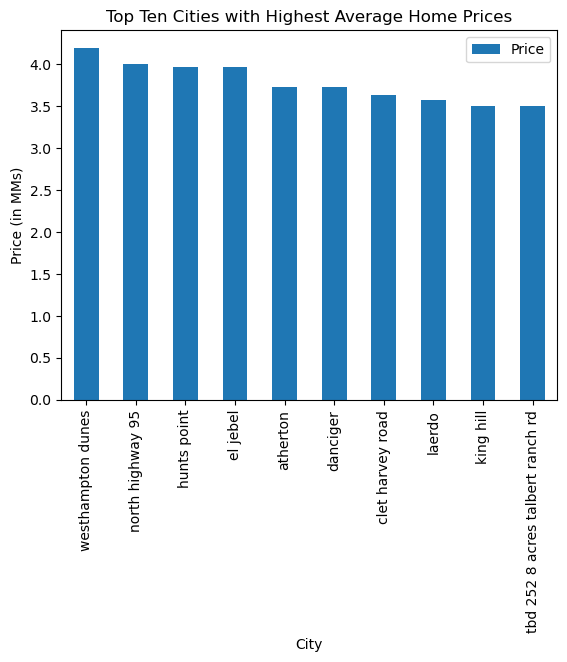

In [208]:
avg_price_city = RE_data[['city','price']]\
                .groupby('city')\
                .mean()\
                .nlargest(10,'price')\
                .rename(columns={'price':'Price'})
avg_price_city.index.name = 'City'

avg_price_city['Price'] = avg_price_city['Price'].apply(as_millions) 
                
avg_price_city

avg_price_city.plot(kind='bar');
plt.ylabel('Price (in MMs)');
plt.title('Top Ten Cities with Highest Average Home Prices');

# Clustering

## K-mean

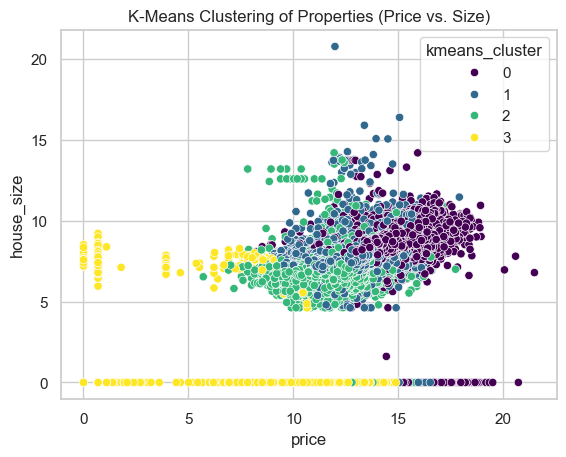

In [245]:
features = ['price', 'bed', 'bath', 'house_size']
realtor_cluster = realtor_data[features].dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(realtor_cluster)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
realtor_data['kmeans_cluster'] = kmeans.fit_predict(scaled_data)
sns.scatterplot(x=realtor_data['price'], y=realtor_data['house_size'], hue=realtor_data['kmeans_cluster'], palette='viridis')
plt.title("K-Means Clustering of Properties (Price vs. Size)")
plt.show()

Results: 

## DBSCAN

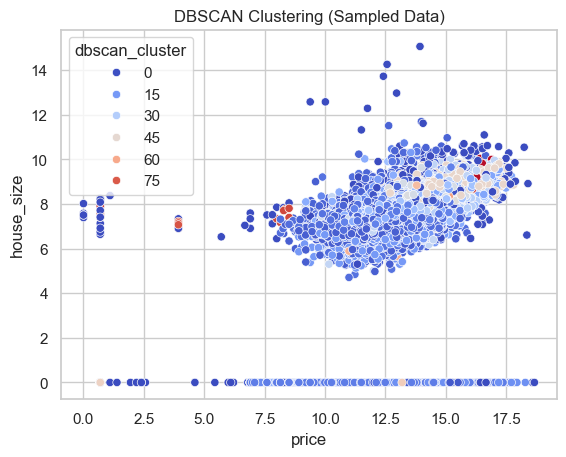

In [256]:
sampled_data = realtor_data.sample(frac=0.1, random_state=42)
scaled_sampled_data = scaler.transform(sampled_data[features])
dbscan = DBSCAN(eps=0.5, min_samples=5)
sampled_data['dbscan_cluster'] = dbscan.fit_predict(scaled_sampled_data)
sns.scatterplot(x=sampled_data['price'], y=sampled_data['house_size'], hue=sampled_data['dbscan_cluster'], palette='coolwarm')
plt.title("DBSCAN Clustering (Sampled Data)")
plt.show()

Results:

## GMM

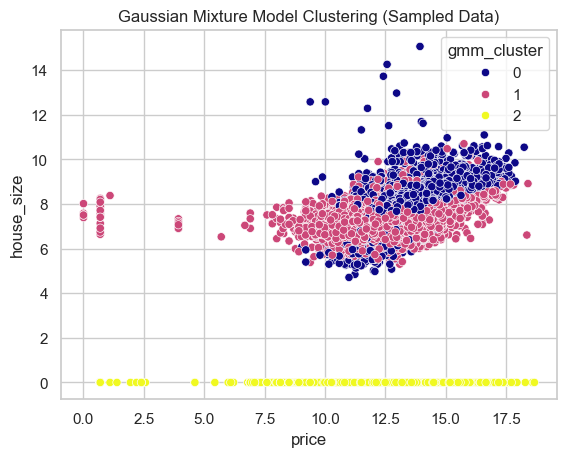

In [258]:
sampled_data = realtor_data.sample(frac=0.1, random_state=42) 
scaled_sampled_data = scaler.transform(sampled_data[features])
gmm = GaussianMixture(n_components=3, random_state=42)
sampled_data['gmm_cluster'] = gmm.fit_predict(scaled_sampled_data)
sns.scatterplot(x=sampled_data['price'], y=sampled_data['house_size'], hue=sampled_data['gmm_cluster'], palette='plasma')
plt.title("Gaussian Mixture Model Clustering (Sampled Data)")
plt.show()

Results:

## PCA

Non-numeric columns: Index(['brokered_by', 'status', 'street', 'city', 'state', 'prev_sold_date'], dtype='object')


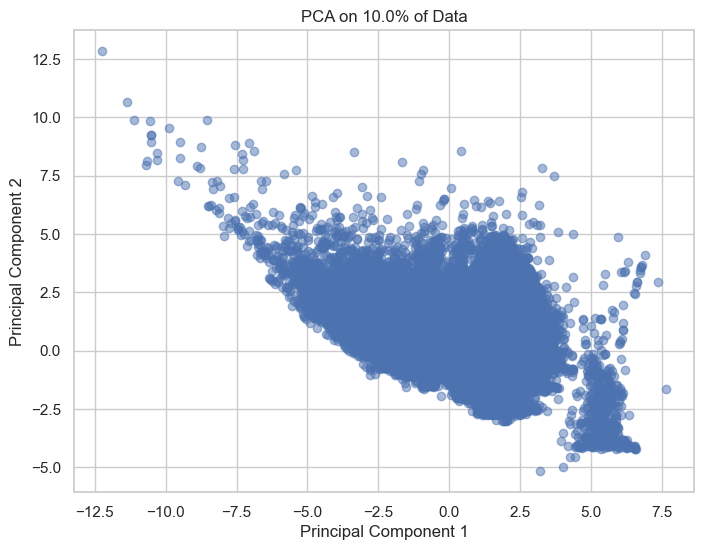

In [268]:
fraction = 0.1
subset = realtor_data.sample(frac=fraction, random_state=42)
non_numeric_cols = subset.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)
subset_numeric = subset.drop(columns=non_numeric_cols)
scaler = StandardScaler()
scaled_subset = scaler.fit_transform(subset_numeric)
pca = PCA(n_components=2)  # Adjust the number of components as needed
pca_result = pca.fit_transform(scaled_subset)
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"PCA on {fraction * 100}% of Data")
plt.show()

Use full_model to see if weights are statistically significant for linear regression

In [316]:
scaler = StandardScaler()
scaler.fit_transform(realtor_data_copy[['price']])
standardized_prediction = -0.3
original_price = scaler.inverse_transform([[standardized_prediction]])[0][0]
original_price

-0.3